In [1]:
from numpy import nan_to_num, array, empty_like, empty, vstack, concatenate, linspace, tile
import numpy as np
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
import pickle
import gzip

In [2]:
%matplotlib inline

# Building extended covariance matrices for EEG-based BCI

## Loading EEG data

from [Database](https://github.com/sylvchev/dataset-ssvep-exoskeleton/). The stimulation onsets are indicated in `event_pos` and the stimulation of `event_type` are coded as follow: 33024, 33025, 33026 and 33027 denote respectively the resting class, the 13 Hz, the 21 Hz and the 17 Hz stimulations. 

In [3]:
## open file and get data without MNE
with gzip.open('../data/record-[2012.07.06-19.06.14].pz', 'rb') as f:
    o = pickle.load(f, encoding='latin1')
raw_signal = o['raw_signal'].T
event_pos = o['event_pos'].reshape((o['event_pos'].shape[0]))
event_type = o['event_type'].reshape((o['event_type'].shape[0]))
sfreq = 256
classes = ['Resting', '13Hz', '21Hz', '17Hz']
channels = array(['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'])

In [4]:
## Get Labels through event number and create a string vector with class names
labels = list()
for e in event_type:
    if e == 33024: labels.append('Resting')
    elif e == 33025: labels.append('13Hz')
    elif e == 33026: labels.append('21Hz')
    elif e == 33027: labels.append('17Hz')
labels = array(labels)

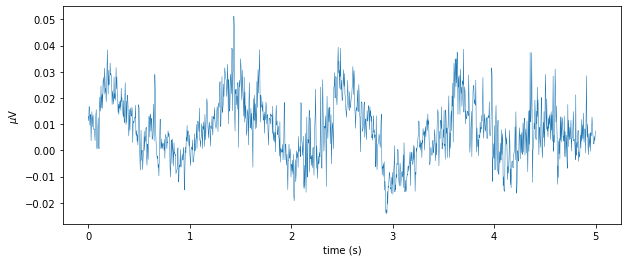

In [5]:
# Plot only Oz electrode (5 seconds) 
n_seconds = 5
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(10, 4))
plt.plot(time.T, raw_signal[channels == 'Oz', :n_seconds*sfreq].T, lw=0.5)
plt.xlabel("time (s)")
_ = plt.ylabel(r"$\mu$V")

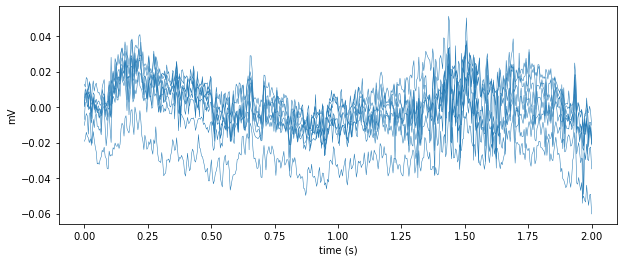

In [6]:
# Plot all electrodes signals (2 seconds)
n_seconds = 2
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(10, 4))
plt.plot(time.T, raw_signal[:, :n_seconds*sfreq].T, color='C0', lw=0.5)
plt.xlabel("time (s)")
_ = plt.ylabel(r"mV")

### Filtering: Pure butterworth

In [7]:
# Butterworth bandpass filter, 4th order by default
def butter_bandpass(signal, lowcut, highcut, fs=256, order=4, filttype='forward-backward'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    if filttype == 'forward':
        filtered = lfilter(b, a, signal, axis=-1)
    elif filttype == 'forward-backward':
        filtered = filtfilt(b, a, signal, axis=-1)
    else:
        raise ValueError("Unknown filttype:", filttype)    
    return filtered

In [10]:
# Main Method with butterworth filtering and no MNE
frequencies = [13., 17., 21.]
freq_band = 0.1    
ext_signal = np.vstack([butter_bandpass(raw_signal,
                                         lowcut=f-freq_band,
                                         highcut=f+freq_band,
                                         )
                        for f in frequencies])
# Remove first Trial of signal for signal fidelity purposes
ext_signal = ext_signal[1:,:]

### Filtering alternative: MNE filter

In [11]:
## Alternative option of signal filtering through MNE library
from mne import create_info
from mne.io import Raw, RawArray

# MNE Filter function
def _bandpass_filter(signal, lowcut, highcut):
    """ Bandpass filter using MNE """
    return signal.copy().filter(l_freq=lowcut, h_freq=highcut,
                                method="iir").get_data()

# get MNE Raw object from same record
raw_fname = '../data/record-[2012.07.06-19.06.14]_raw.fif'
mne_raw = Raw(raw_fname, preload=True, verbose=False)

# Pass filter 3 times, to each frequency and put together in a ext_signal
# freq_band implies in the range of frequency cut (freq+-freq_band)
frequencies = [13., 17., 21.]
freq_band = 0.1    
mne_ext_signal = np.vstack([_bandpass_filter(mne_raw,
                                         lowcut=f-freq_band,
                                         highcut=f+freq_band,
                                         )
                        for f in frequencies])

# Remove first Trial of signal for signal fidelity purposes
mne_ext_signal = mne_ext_signal[1:,:]


## Get trial for each filtered signal methods

In [12]:
# Separate signal in trials by identifier "32779"
# value that identifies a trial change in recording
ext_trials = list()
for e, t in zip(event_type, event_pos):
    if e == 32779: # start of a trial
        start = t + 2*sfreq
        stop = t + 5*sfreq
        ext_trials.append(ext_signal[:, start:stop])
ext_trials = array(ext_trials)
ext_trials = ext_trials - tile(ext_trials.mean(axis=2).reshape(ext_trials.shape[0], 
                            ext_trials.shape[1], 1), (1, 1, ext_trials.shape[2]))

In [13]:
# Same as above but for MNE Signal
mne_ext_trials = list()
for e, t in zip(event_type, event_pos):
    if e == 32779: # start of a trial
        start = t + 2*sfreq
        stop = t + 5*sfreq
        mne_ext_trials.append(mne_ext_signal[:, start:stop])
mne_ext_trials = array(mne_ext_trials)
mne_ext_trials = mne_ext_trials - tile(mne_ext_trials.mean(axis=2).reshape(mne_ext_trials.shape[0], 
                            mne_ext_trials.shape[1], 1), (1, 1, mne_ext_trials.shape[2]))

## Visualization of filtered signal
#### Comparision between pure and MNE filtering

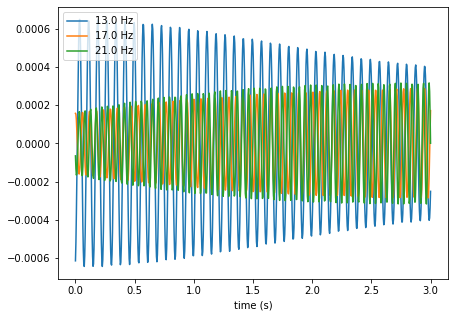

In [14]:
# Plot of signal filtered by frequencies
# Filtered by Buttersworth filter (NO MNE)
n_seconds = 3
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(7, 5))
plt.plot(time.T, ext_trials[2, 0, :].T, label=str(frequencies[0])+' Hz')
plt.plot(time.T, ext_trials[2, 8, :].T, label=str(frequencies[1])+' Hz')
plt.plot(time.T, ext_trials[2, 16, :].T, label=str(frequencies[2])+' Hz')
plt.xlabel("time (s)")
_ = plt.legend(loc='upper left')

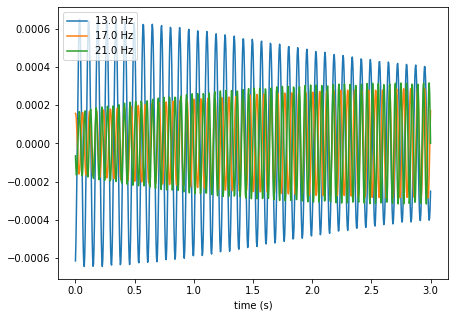

In [15]:
# Plot of signal filtered by frequencies
# Filtered by MNE
n_seconds = 3
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(7, 5))
plt.plot(time.T, mne_ext_trials[2, 0, :].T, label=str(frequencies[0])+' Hz')
plt.plot(time.T, mne_ext_trials[2, 8, :].T, label=str(frequencies[1])+' Hz')
plt.plot(time.T, mne_ext_trials[2, 16, :].T, label=str(frequencies[2])+' Hz')
plt.xlabel("time (s)")
_ = plt.legend(loc='upper left')

## Spatial covariance estimation

The covariance matrices will be estimated using the Ledoit-Wolf shrinkage estimator.

In [16]:
from pyriemann.estimation import Covariances

cov_ext_trials = Covariances(estimator='lwf').transform(ext_trials)

### Visualisation of the covariance matrices
The matrix plot shows the block structure resulting from the extended signal. Most of the signal energy is concentrated in the 13 Hz frequency band.

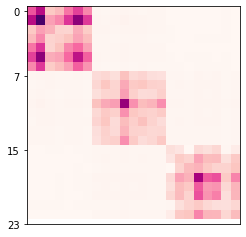

In [17]:
plt.figure()
plt.imshow(cov_ext_trials[0, :, :], 
           cmap=plt.get_cmap('RdPu'), 
           interpolation='nearest')
plt.xticks([])
_ = plt.yticks([0, 7, 15, 23])

The next plot shows an example of the first covariance matrix observed for each class:

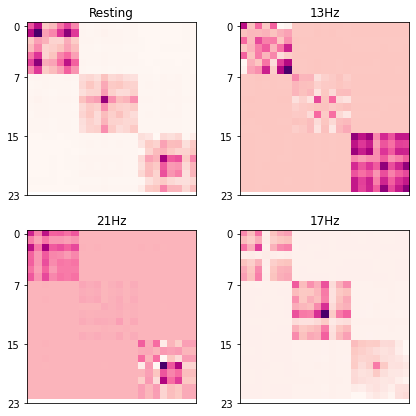

In [18]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(cov_ext_trials[labels == l, :, :][0, :, :], 
               cmap=plt.get_cmap('RdPu'), 
               interpolation='nearest')
    plt.xticks([])
    plt.yticks([0, 7, 15, 23])
    _ = plt.title(l)

# Appendix
Try to use cov matrices to train and predict

In [19]:
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.distance import distance_riemann

labels = list()
for e in event_type:
    if e == 33024: labels.append('Resting')
    elif e == 33025: labels.append('13Hz')
    elif e == 33026: labels.append('21Hz')
    elif e == 33027: labels.append('17Hz')
labels = array(labels)



y_train = labels[::2] # take even indexes
y_test = labels[1::2] # take odd indexes

cov_train = cov_ext_trials[::2]
cov_test = cov_ext_trials[1::2]


# with gzip.open('./data/record-[2014.03.10-19.47.49].pz', 'rb') as f:
#     o = pickle.load(f, encoding='latin1')
# cov_train = o['cov_train']
# cov_test = o['cov_test']
# y_train = o['y_train']
# y_test = o['y_test']
# classes = o['classes']
cov_centers = empty((len(classes), 23, 23))

for i, l in enumerate(classes):
    cov_centers[i, :, :] = mean_riemann(cov_train[y_train == l, :, :])

accuracy = list()
for sample, labels in zip(cov_test, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(len(classes))]
    if classes[array(dist).argmin()] == labels:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)


Evaluation accuracy on test set is 56.25%
